In [ ]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt

In [ ]:
df_rent = pd.read_csv('df_rent_final.csv')

In [ ]:
df_bars = pd.read_csv('df_bars_merge.csv')

# Гипотеза 1

Первая гипотеза: чем ближе помещение аренды находится к метро, тем выше будет цена за квадратный метр у помещения

Нулевая гипотеза (H₀)

Между расстоянием до ближайшего метро и ценой аренды за квадратный метр отсутствует статистически значимая зависимость.

Альтернативная гипотеза (H₁)

Между расстоянием до ближайшего метро и ценой аренды за квадратный метр существует отрицательная зависимость:
чем ближе помещение к метро, тем выше цена за квадратный метр.

In [ ]:
df_rent_msk = df_rent[df_rent['city'] == 'Москва']
df_rent_spb = df_rent[df_rent['city'] == 'Санкт-Петербург']

**Начнем с Москвы**

In [ ]:
from scipy.stats import shapiro

In [ ]:
distance_msk = df_rent_msk['distance_km'].values
price_msk = df_rent_msk['price_per_sqm, rub/month'].values

distance_spb = df_rent_spb['distance_km'].values
price_spb = df_rent_spb['price_per_sqm, rub/month'].values


In [ ]:
statistic_distanceMsk, pvalue_distanceMsk = shapiro(distance_msk)
statistic_priceMsk, pvalue_priceMsk = shapiro(price_msk)

statistic_distanceSpb, pvalue_distanceSpb = shapiro(distance_spb)
statistic_priceSpb, pvalue_priceSpb = shapiro(price_spb)

print(pvalue_distanceMsk, pvalue_priceMsk)
print(pvalue_distanceSpb, pvalue_priceSpb)

1.78166066993768e-67 2.6951921665915103e-77
1.027854472942738e-42 1.838404082622556e-46


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6174.
  res = hypotest_fun_out(*samples, **kwds)


Критерий Шапиро-Уилка показывает, что данные распределы ненормально (для Москвы и Питера), и мы имеем дело с numeric data и измеряем relationship между multiple variabls, сл - но применим корреляцию spearman

Критерий Спирмана

In [ ]:
res_spearmanr_msk = stats.spearmanr(distance_msk, price_msk)
res_spearmanr_spb = stats.spearmanr(distance_spb, price_spb)
print(res_spearmanr_msk.statistic, res_spearmanr_msk.pvalue)
print(res_spearmanr_spb.statistic, res_spearmanr_spb.pvalue)


-0.2877218290234132 5.427553898675386e-118
-0.17242097470603462 2.6228924397482788e-11


В обоих случаях: p-value < 0.05, сл - но вероятность получить такую корреляцию случайно при отсутствии связи практически равна нулю.

Следствие:
Нулевая гипотеза (H₀) отвергается и для Москвы, и для Санкт-Петербурга.

Знак и величина коэффициента Спирмена

Отрицательный знак - связь обратная

По модулю:

Москва: |statistic| ~ 0.29 - умеренная отрицательная связь

СПб: |statistic| ~ 0.17 - слабая отрицательная связь

Чем ближе помещение к метро, тем выше цена за квадратный метр.
Эффект есть в обоих городах, но сильнее выражен в Москве.

#Гипотеза 2

Проверим сколько пропусков для каждого города по среднему чеку

In [ ]:
df_bars_m = df_bars[df_bars["city"]=="Москва"]
df_bars_p = df_bars[df_bars["city"]=="Санкт-Петербург"]

In [ ]:
print(f"Cледовательно у нас около {round(1 - df_bars_m.dropna(subset=["attributes"]).shape[0] / df_bars_m.shape[0] , 3)*100}% пропусков в разделе с чеками в Москве")

Cледовательно у нас около 47.599999999999994 пропусков в разделе с чеками в Москве


In [ ]:
print(f"Cледовательно у нас около {round(1 - df_bars_p.dropna(subset=["attributes"]).shape[0] / df_bars_p.shape[0] , 3)*100}% пропусков в разделе с чеками в Питере")

Cледовательно у нас около 36.8 пропусков в разделе с чеками в Питере


In [ ]:
df_dropped_bars_m = df_bars_m.dropna(subset=["attributes"])
df_dropped_bars_p = df_bars_p.dropna(subset=["attributes"])

Определим гипотезы:

H0: в москве чеки не больше чем в питере

H1: в москве чеки больше чем в питере

In [ ]:
from scipy import stats as st

u, p = st.mannwhitneyu(
    df_dropped_bars_m["attributes"],
    df_dropped_bars_p["attributes"],
    alternative="greater"
)
print(f"u = {u}, p-value = {p}")


u = 472716.5, p-value = 1.6175803662289644e-28


Отвергаем H0, сл-но чеки в Москве статистически значимо выше, чем в Питере

#Гипотеза 3

Сначала проверим на нормальность

In [ ]:
bars_dropped = df_bars.dropna(subset=["city","district","reviews.general_rating"])

dist = bars_dropped.groupby(["city","district"]).agg(
            bar_count=("name","size"),
            mean_rating=("reviews.general_rating","mean"))

dist.reset_index(inplace=True)
dist

,city,district,bar_count,mean_rating
0,Москва,Академический район,13,4.515385
1,Москва,Алтуфьевский район,6,4.383333
2,Москва,Бескудниковский район,11,4.345455
3,Москва,Бутырский район,35,4.548571
4,Москва,Войковский район,6,4.150000
...,...,...,...,...
84,Санкт-Петербург,округ Сосновское,5,4.380000
85,Санкт-Петербург,округ Суздальское,6,4.716667
86,Санкт-Петербург,округ Чкаловское,18,4.744444
87,Санкт-Петербург,округ Юнтолово,15,4.293333


In [ ]:
dist_m = dist[dist["city"] == "Москва"]
dist_p = dist[dist["city"] == "Санкт-Петербург"]

In [ ]:
stat_normal, p_value_normal = stats.shapiro(dist_m["mean_rating"])
print(f"Нормальные данные: Статистика W = {stat_normal:.4f}, p-value = {p_value_normal:.4f}")

Нормальные данные: Статистика W = 0.9910, p-value = 0.9454


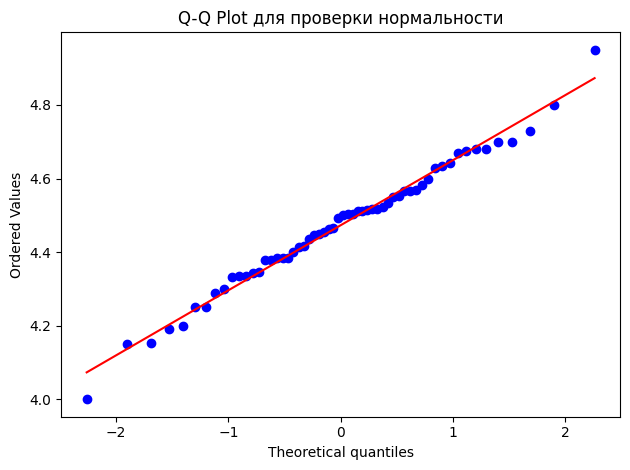

In [ ]:
stats.probplot(dist_m["mean_rating"], dist="norm", plot=plt)
plt.title("Q-Q Plot для проверки нормальности")

plt.tight_layout()
plt.show()

In [ ]:
stat_normal, p_value_normal = stats.shapiro(dist_p["mean_rating"])
print(f"Нормальные данные: Статистика W = {stat_normal:.4f}, p-value = {p_value_normal:.4f}")

Нормальные данные: Статистика W = 0.9647, p-value = 0.3863


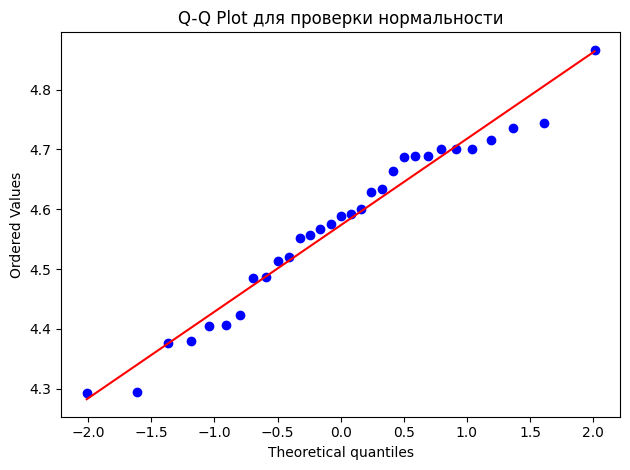

In [ ]:
stats.probplot(dist_p["mean_rating"], dist="norm", plot=plt)
plt.title("Q-Q Plot для проверки нормальности")

plt.tight_layout()
plt.show()

Получается что данные распределены нормально, а значит можно использовать коэф Пирсона для проверки гипотез

H0: между количеством баров в районе и средней оценкой баров в районе нет связи

H1: чем меньше баров в районе, тем выше средняя оценка

In [ ]:
r, p = stats.pearsonr(dist_m["bar_count"], dist_m["mean_rating"], alternative="less")

print(f"r: {r} \np: {p}")

r: -0.010244783100362564 
p: 0.4695800817113294


Для Москвы

r близок к 0 и отрицателен это значит, что линейная связь отрицательная хоть ее почти нет.

Статистически значимой линейной связи не найдено.
p = 0.469, поэтому H0 не отвергается.


In [ ]:
r, p = stats.pearsonr(dist_p["bar_count"], dist_p["mean_rating"], alternative="less")

print(f"r: {r} \np: {p}")

r: -0.0763747698757106 
p: 0.6830099038132538


Для Питера

r близок к 0 и отрицателен это значит, что линейная связь отрицательная хоть ее почти нет.

Статистически значимой линейной связи не найдено.
p = 0.683, поэтому H0 не отвергается.

#Гипотеза 4

Мы хотим понять, как цена за квадратный метр коммерческой недвижимости связана с размером, то есть площадью, помещения

Общая гипотеза: Размер помещения влияет на стоимость квадратного метра в аренде

У нас есть деление на 5 основных групп по площадям: маленькая, средняя, большая, крупная и очень крупная. Будем рассматривать отдельно тесты для Москвы и Санкт-Петербурга

Тест 1. Краскала-Уоллиса


Для теста:
- не требует предположения о нормальности распределения данных
- устойчив к выбросам, так как использует ранги вместо исходных значений
- подходит для порядковых данных, может анализировать ранги и рейтинги
- у нас есть больше 2 групп
- данные порядковые


Гипотезы:

$H_{0}$: $M_{1} = M_{2} = M_{3} = M_{4} = M_{5}$, где $M_{n}$ - это медианая цена за квадратный метр в нашем типе площади в рассматриваемом городе

$H_{1}$: $M_{i} \ne M_{j}$, то есть у нас существуют статистически значимые различия в медианах цен между хотя бы одной парой категорий площади в рассматриваем городе

In [ ]:
df_Moscow = df_rent[df_rent['city'] == 'Москва']
df_spb = df_rent[df_rent['city'] == 'Санкт-Петербург']

In [ ]:
group1 = df_Moscow[df_Moscow['square_category'] == 'Маленькая']['price_per_sqm, rub/month']
group2 = df_Moscow[df_Moscow['square_category'] == 'Средняя']['price_per_sqm, rub/month']
group3 = df_Moscow[df_Moscow['square_category'] == 'Большая']['price_per_sqm, rub/month']
group4 = df_Moscow[df_Moscow['square_category'] == 'Крупная']['price_per_sqm, rub/month']
group5 = df_Moscow[df_Moscow['square_category'] == 'Очень крупная']['price_per_sqm, rub/month']

group6 = df_spb[df_spb['square_category'] == 'Маленькая']['price_per_sqm, rub/month']
group7 = df_spb[df_spb['square_category'] == 'Средняя']['price_per_sqm, rub/month']
group8 = df_spb[df_spb['square_category'] == 'Большая']['price_per_sqm, rub/month']
group9 = df_spb[df_spb['square_category'] == 'Крупная']['price_per_sqm, rub/month']
group10 = df_spb[df_spb['square_category'] == 'Очень крупная']['price_per_sqm, rub/month']

In [ ]:
result1 = stats.kruskal(group1, group2, group3, group4, group5)
result1

KruskalResult(statistic=np.float64(720.777419434221), pvalue=np.float64(1.104451400151417e-154))

In [ ]:
result1 = stats.kruskal(group6, group7, group8, group9, group10)
result1

KruskalResult(statistic=np.float64(80.87665564257262), pvalue=np.float64(1.1356894505738264e-16))

p_value < 0.05, поэтому отклоняем $H_{0}$, то есть медианные цены в группах точно различаются и возможно есть какая-то зависимость
в обоих городах

Проверим, что действительно есть какая-то зависимость с помощью критерия Спирмана

Гипотезы:

$H_{0}$: отсутствует корреляционная связь между площадью и ценой за квадратый метр

$H_{1}$: есть корреляционая связь между площадью и ценой за квадратый метр

In [ ]:
spearman_corr1, spearman_p1 = stats.spearmanr(df_Moscow['square, m^2'], df_Moscow['price_per_sqm, rub/month'])

In [ ]:
spearman_p1

np.float64(4.760869723597501e-155)

In [ ]:
spearman_corr1

np.float64(-0.3282668734565767)

In [ ]:
spearman_corr2, spearman_p2 = stats.spearmanr(df_spb['square, m^2'], df_spb['price_per_sqm, rub/month'])

In [ ]:
spearman_p2

np.float64(1.0002217717238841e-18)

In [ ]:
spearman_corr2

np.float64(-0.2272231508886957)

Получается, что у нас p_value < 0.05, поэтому отклоняем $H_{0}$. Получается, что у нас есть какая-то зависимость между площадью помещения и ценой за квадратный метр в обоих городах

Критерий Краскела — Уоллиса указывает на наличие значимых различий и критерий Спирмена показал зависимость, можно применить критерий Данна, чтобы определить, какие именно пары групп существенно отличаются друг от друга. Критерий Данна предназначен для попарных сравнений после получения значимого результата критерия Краскела — Уоллиса и позволяет выявить различия между конкретными группами

Для каждой пары у нас есть гипотезы:

$H_{0}$: предположение об отсутствии эффекта или различий

$H_{1}$: предположение о наличии эффекта, различия или влияния

In [ ]:
import scikit_posthocs as sp

In [ ]:
df_rent.tail(1)

,"rent, rub/month",address,city,"price_per_sqm, rub/month","square, m^2",type,url,OSM_address,address_info,district,lat,lon,nearest_metro,distance_km,distance_center_km,distance_center_m,square_category,square_category_encoding,ordered_code
7648,1200000,Пятницкая,Москва,4000,300,Помещение под бар/ресторан,https://msk.n1.ru/view/112067957/?open_card_kn,"Пятницкая, 30 ст1, Москва, Россия","{'district': 'район Митино', 'lat': 55.8509482...",район Митино,55.850948,37.365869,"Москва, Митино",0.618436,19.34,19340,Крупная,4,4


In [ ]:
dunn_results1 = sp.posthoc_dunn(df_Moscow, val_col='price_per_sqm, rub/month', group_col='square_category_encoding')

In [ ]:
dunn_results1 < 0.05

,1,2,3,4,5
1,False,True,True,True,True
2,True,False,True,True,True
3,True,True,False,True,True
4,True,True,True,False,True
5,True,True,True,True,False


In [ ]:
dunn_results2 = sp.posthoc_dunn(df_spb, val_col='price_per_sqm, rub/month', group_col='square_category_encoding')

In [ ]:
dunn_results2 < 0.05

,1,2,3,4,5
1,False,True,True,True,True
2,True,False,False,True,True
3,True,False,False,True,True
4,True,True,True,False,True
5,True,True,True,True,False


Видим, какие пары категорий статистически значимо различаются по цене, в нашем случае все пары

При этом корреляция Спирмена показала отрицательное значение, поэтому можем сделать вывод, что чем больше площадь, тем ниже цена

Вывод для Москвы:
- каждая категория имеет уникальную ценовую позицию
- цена за м² последовательно снижается с увеличением площади

Тогда арендаторам в Москве не выгодно арендовать маленькие помещения

Вывод для Питера:
- средняя и большая площади находятся в одной ценовой политики
- цена за м² последовательно снижается с увеличением площади

Тогда арендаторам в Питере не выгодно арендовать маленькие и средние помещения

# Гипотеза 5

In [ ]:
df_rent = pd.read_csv("df_rent.csv")
df_rent.head(3)

,"rent, rub/month",address,city,"price_per_sqm, rub/month","square, m^2",type,url,OSM_address,address_info,district,lat,lon,nearest_metro,distance_km,distance_center_km,distance_center_m,square_category,square_category_encoding
0,200000,Тосина,Санкт-Петербург,2361,84,Универсальное помещение,https://spb.n1.ru/view/115905928/?open_card_kn,"Тосина, 1 корп. 2, Санкт-Петербург, Россия","{'district': 'округ Волковское', 'lat': 59.902...",округ Волковское,59.902662,30.349236,"Санкт-Петербург, Волковская",0.879784,4.50,4500,Средняя,1.0
1,330000,Заставская,Санкт-Петербург,6600,50,Универсальное помещение,https://spb.n1.ru/view/115285927/?open_card_kn,"Заставская, 30, Санкт-Петербург, Россия","{'district': 'округ Московская застава', 'lat'...",округ Московская застава,59.887331,30.343781,"Санкт-Петербург, Волковская",1.249201,5.93,5930,Средняя,1.0
2,490000,Науки проспект,Санкт-Петербург,8750,56,Универсальное помещение,https://spb.n1.ru/view/115986821/?open_card_kn,"Науки проспект, 23 корп. 2, Санкт-Петербург, Р...","{'district': 'округ Пискарёвка', 'lat': 60.003...",округ Пискарёвка,60.003741,30.435211,"Санкт-Петербург, Академическая",2.414211,10.22,10220,Средняя,1.0


In [ ]:
df_rent_m = df_rent[df_rent["city"]=="Москва"]
df_rent_p = df_rent[df_rent["city"]=="Санкт-Петербург"]

Определим гипотезы:

H0: в москве цена за квадратный метр не больше чем в питере

H1: в москве цена за квадратный метр больше чем в питере

In [ ]:
u, p = stats.mannwhitneyu(
    df_rent_m["price_per_sqm, rub/month"],
    df_rent_p["price_per_sqm, rub/month"],
    alternative="greater"
)

print(f"u = {u}, p-value = {p}")


u = 4423665.5, p-value = 8.858796063157108e-172


Отвергаем H0: цена за квадратный метр в Москве статистически значимо выше, чем в Питере
